In [6]:
import numpy as np
import h5py
import pandas as pd
from glob import glob
import os
import re
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker
# settings
color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

np.set_printoptions(precision=2)

from IPython.display import clear_output

# grb codes
import PyBlastAfterglowMag as PBA
try:
    import afterglowpy as grb
except:
    afterglowpy = False
    print("Error! could not import afteglowpy")


# Jet Settings (TopHat)

In [7]:
workingdir = os.getcwd()+'/'
pba_src = "/home/vsevolod/Work/GIT/GitHub/PyBlastAfterglowMag/src/pba.out"
loglevel= "info"
structure = {
    "struct":"tophat",
    "Eiso_c":1.e53, "Gamma0c": 300., "M0c": -1.,
    "theta_c": np.pi / 10, "theta_w": np.pi / 10, "nlayers_pw": 150, "nlayers_a": 1
    }

# Compare with Afterglowpy

In [8]:
# run code 
PBA.parfile_tools.modify_parfile_par_opt(workingdir=workingdir, part="grb",keep_old=False,newparfile="parfile.par",
                                         newpars={},newopts={"method_synchrotron":"Joh06",
                                                             "fname_light_curve":"lc_syn_joh.h5",
                                                             "fname_spectrum":"spec_syn_joh.h5"})
pba_id = PBA.id_analytic.JetStruct(n_layers_pw=structure["nlayers_pw"], n_layers_a=structure["nlayers_a"])
pba_id.save_1d_id(*pba_id.get_1D_id(pars=structure, type="adaptive"), outfpath=workingdir+"grb_id.h5")
pba = PBA.interface.PyBlastAfterglow(workingdir=workingdir, readparfileforpaths=True, parfile="parfile.par")
pba.run(path_to_cpp_executable=pba_src,loglevel=loglevel)
clear_output(wait=False)

[ INFO    ] : [ main.cpp:152 ] : Computation tgrid = [100, 9.63829e+17] n=1000
[ INFO    ] : [ main.cpp:153 ] : Output      tgrid = [100, 9.63829e+17] n=1000
[ INFO    ] : [ model_magnetar.h:569 ] : Magnetar is not initialized and will not be considered.
[ INFO    ] : [ ejecta_id.h:206 ] :  1D ID has theta_wing=0.314159 theta_core=0.314159
[ INFO    ] : [ ejecta_id.h:258 ] : Initial data loaded with nshells=1 m_nlayers=1
[ INFO    ] : [ ejecta_id.h:280 ] : Angular grids are initialized. nshells=1 m_nlayers=1
[ INFO    ] : [ ejecta_id.h:303 ] : Energy and mass are rescaled.
[ WARNING ] : [ blastwave_base.h:104 ] : Parameter theta_max not given. Using default value=1.5708
[ WARNING ] : [ blastwave_base.h:107 ] : Parameter epsilon_e_rad not given. Using default value=0
[ WARNING ] : [ blastwave_radiation.h:873 ] : Parameter theta_max not given. Using default value=1.5708
[ WARNING ] : [ blastwave_radiation.h:880 ] : Parameter theta_max not given. Using default value=1.5708
[ WARNING ] : [

[ ERROR   ] : [ radiation.h:1884 ] : 

CalledProcessError: Command '['/home/vsevolod/Work/GIT/GitHub/PyBlastAfterglowMag/src/pba.out', '/home/vsevolod/Work/GIT/GitHub/PBA_projects/grbafg/tophat_ssc/', 'parfile.par', 'info']' returned non-zero exit status 1.

In [13]:
# plot dynamics
def plot_dynamics():
    pass

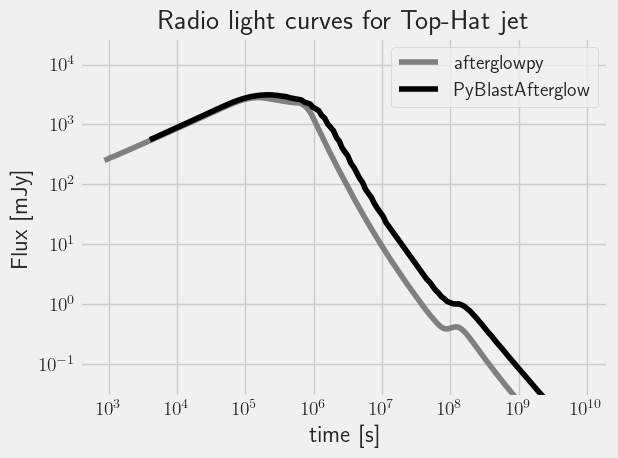

In [14]:
# Compare Light Cruves
def compare_lcs(pba : PBA.interface.PyBlastAfterglow, struct : dict, obs_freq : float):
    pars = {**pba.GRB.pars,**pba.main_pars}
    Z = {'jetType':     grb.jet.TopHat if struct["struct"] == "tophat" else grb.jet.Gaussian,     # Top-Hat jet
             'specType':    0,                  # Basic Synchrotron Spectrum
             'counterjet':  1,
             'spread':      7,
             'thetaObs':    pars["theta_obs"],   # Viewing angle in radians
             'E0':          struct["Eiso_c"], # Isotropic-equivalent energy in erg
             'g0':          struct["Gamma0c"],
             'thetaCore':   struct["theta_c"],    # Half-opening angle in radians
             'thetaWing':   struct["theta_w"],
             'n0':          pars["n_ism"],    # circumburst density in cm^{-3}
             'p':           pars["p"],    # electron energy distribution index
             'epsilon_e':   pars["eps_e"],    # epsilon_e
             'epsilon_B':   pars["eps_b"],   # epsilon_B
             'xi_N':        1.0,    # Fraction of electrons accelerated
             'd_L':         pars["d_l"], # Luminosity distance in cm
             'z':           pars["z"]}   # redshift
        
    t = np.geomspace(1.0 * 864.0, 1.0e5 * 86400.0, 400)
    nu = np.empty(t.shape)
    nu[:] = obs_freq
    Fnu = grb.fluxDensity(t, nu, **Z)

    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.plot(t,Fnu,color="gray",label="afterglowpy")
    ax.plot(pba.GRB.get_lc_times(spec=False,unique=True),
            pba.GRB.get_lc_totalflux(freq=obs_freq,time=None,spec=False),
            color="black",label="PyBlastAfterglow")
    ax.set_xlabel("time [s]")
    ax.set_ylabel("Flux [mJy]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    ax.set_ylim(Fnu.max()*1e-5,Fnu.max()*10)
    plt.title("Radio light curves for Top-Hat jet")
    plt.tight_layout()
    plt.show()
compare_lcs(pba, obs_freq=1e9, struct=structure)

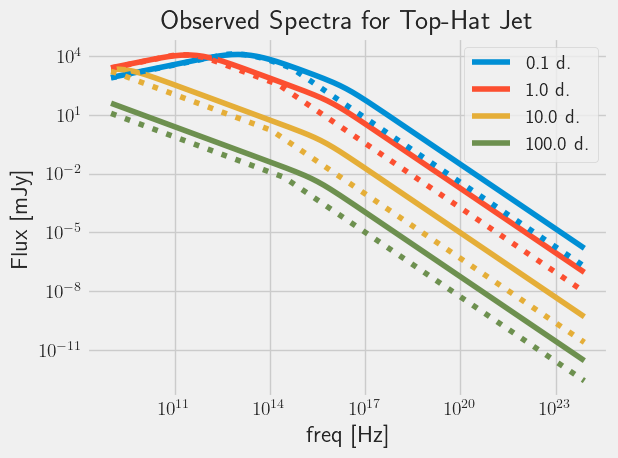

In [15]:
def compare_obs_spectra(pba : PBA.interface.PyBlastAfterglow, struct : dict):
    #        1GHz, 100GHz 1keV      10keV,    1MeV      10MeV     100MeV    1GeV      10GeV     100GeV
    freqs = [1.e9, 1.e11, 2.418e17, 2.418e18, 2.418e20, 2.418e21, 2.418e22, 2.418e23, 2.418e23, 2.418e23]
    freqs = np.array(freqs)
    times = [0.1,1,10,100]
    times = np.array(times)*PBA.utils.cgs.day
    
    pars = {**pba.GRB.pars,**pba.main_pars}
    Z = {'jetType':     grb.jet.TopHat if struct["struct"] == "tophat" else grb.jet.Gaussian,     # Top-Hat jet
             'specType':    0,                  # Basic Synchrotron Spectrum
             'counterjet':  1,
             'spread':      7,
             'thetaObs':    pars["theta_obs"],   # Viewing angle in radians
             'E0':          struct["Eiso_c"], # Isotropic-equivalent energy in erg
             'g0':          struct["Gamma0c"],
             'thetaCore':   struct["theta_c"],    # Half-opening angle in radians
             'thetaWing':   struct["theta_w"],
             'n0':          pars["n_ism"],    # circumburst density in cm^{-3}
             'p':           pars["p"],    # electron energy distribution index
             'epsilon_e':   pars["eps_e"],    # epsilon_e
             'epsilon_B':   pars["eps_b"],   # epsilon_B
             'xi_N':        1.0,    # Fraction of electrons accelerated
             'd_L':         pars["d_l"], # Luminosity distance in cm
             'z':           pars["z"] # redshift
             }   
    
    fig, ax = plt.subplots(ncols=1, nrows=1)
    _freqs = pba.GRB.get_lc_freqs(spec=False,unique=True)
    _times = pba.GRB.get_lc_times(spec=False,unique=True)
    
    for i, t in enumerate(times):
        _flux = pba.GRB.get_lc_totalflux(freq=None,time=t,spec=False)
        ax.plot(_freqs, _flux, color=color_pal[i], label=f"{t/PBA.utils.cgs.day:.1f} d.")
    
    for i, t in enumerate(times):    
        _t = np.full_like(_freqs, t)
        _Fnu = grb.fluxDensity(_t, _freqs, **Z) 
        ax.plot(_freqs, _Fnu, ls=':', color=color_pal[i])

    ax.set_xlabel("freq [Hz]")
    ax.set_ylabel("Flux [mJy]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    plt.title("Observed Spectra for Top-Hat Jet")
    # ax.set_ylim(1e-4,1e6)
    plt.tight_layout()
    plt.show()  
compare_obs_spectra(pba, struct=structure)

# NOTES:
- Light curves and spectra agree. 
- Iportance of SSA in high $n_{\rm ism}$ env. 
- Spectra disagree at early times (coasting phase missing in _afterglowpy_)

# Compare Observed Synchrotron Spectra for 2 Methods

In [1]:
# run code
PBA.parfile_tools.modify_parfile_par_opt(workingdir=workingdir, part="grb",keep_old=False,newparfile="parfile.par",
                                         newpars={},newopts={"method_synchrotron":"Joh06",
                                                             "fname_light_curve":"lc_syn_joh.h5",
                                                             "fname_spectrum":"spec_syn_joh.h5"})
pba_id = PBA.id_analytic.JetStruct(n_layers_pw=structure["nlayers_pw"], n_layers_a=structure["nlayers_a"])
pba_id.save_1d_id(*pba_id.get_1D_id(pars=structure, type="adaptive"), outfpath=workingdir+"grb_id.h5")
pba_j = PBA.interface.PyBlastAfterglow(workingdir=workingdir, readparfileforpaths=True, parfile="parfile.par")
pba_j.run(path_to_cpp_executable=pba_src,loglevel=loglevel)

PBA.parfile_tools.modify_parfile_par_opt(workingdir=workingdir, part="grb",keep_old=False,newparfile="parfile.par",
                                         newpars={},newopts={"method_synchrotron":"Dermer09",
                                                             "fname_light_curve":"lc_syn_der.h5",
                                                             "fname_spectrum":"spec_syn_der.h5"})
pba_id = PBA.id_analytic.JetStruct(n_layers_pw=structure["nlayers_pw"], n_layers_a=structure["nlayers_a"])
pba_id.save_1d_id(*pba_id.get_1D_id(pars=structure, type="adaptive"), outfpath=workingdir+"grb_id.h5")
pba_d = PBA.interface.PyBlastAfterglow(workingdir=workingdir, readparfileforpaths=True, parfile="parfile.par")
pba_d.run(path_to_cpp_executable=pba_src,loglevel=loglevel)
clear_output(wait=False)

NameError: name 'PBA' is not defined

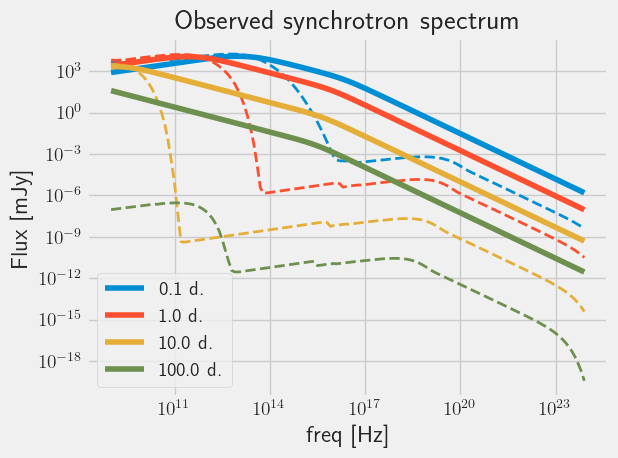

In [17]:
# Compare spectra
def compare_spectra_methods(pba1:PBA.interface.PyBlastAfterglow,
                            pba2:PBA.interface.PyBlastAfterglow):
    #        1GHz, 100GHz 1keV      10keV,    1MeV      10MeV     100MeV    1GeV      10GeV     100GeV
    freqs = [1.e9, 1.e11, 2.418e17, 2.418e18, 2.418e20, 2.418e21, 2.418e22, 2.418e23, 2.418e23, 2.418e23]
    freqs = np.array(freqs)
    times = [0.1,1,10,100]
    times = np.array(times)*PBA.utils.cgs.day

    fig, ax = plt.subplots(ncols=1, nrows=1)
    for i, t in enumerate(times):
        _freqs1 = pba1.GRB.get_lc_freqs(spec=False,unique=True)
        _flux1 = pba1.GRB.get_lc_totalflux(freq=None,time=t,spec=False)
        ax.plot(_freqs1, _flux1, color=color_pal[i], ls='-', label=f"{t/PBA.utils.cgs.day:.1f} d.")

        _freqs2 = pba2.GRB.get_lc_freqs(spec=False,unique=True)
        _flux2 = pba2.GRB.get_lc_totalflux(freq=None,time=t,spec=False)
        ax.plot(_freqs2, _flux2, color=color_pal[i], ls='--',lw=2)

    ax.set_xlabel("freq [Hz]")
    ax.set_ylabel("Flux [mJy]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    # ax.set_ylim(1e-4,1e6)
    plt.title("Observed synchrotron spectrum")
    plt.tight_layout()
    plt.show()  
compare_spectra_methods(pba1=pba_j,pba2=pba_d)

# Compare Comoving Synchrotron Spectra for 2 Methods

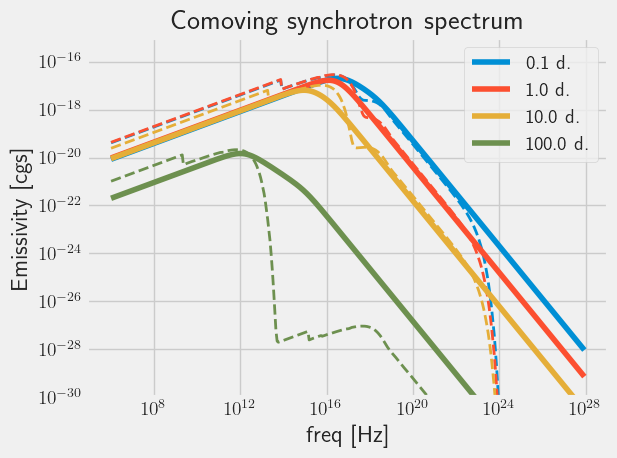

In [18]:
def compare_comov_spectra_methods(pba1:PBA.interface.PyBlastAfterglow,
                                  pba2:PBA.interface.PyBlastAfterglow):
    #        1GHz, 100GHz 1keV      10keV,    1MeV      10MeV     100MeV    1GeV      10GeV     100GeV
    freqs = [1.e9, 1.e11, 2.418e17, 2.418e18, 2.418e20, 2.418e21, 2.418e22, 2.418e23, 2.418e23, 2.418e23]
    freqs = np.array(freqs)
    times = [0.1,1,10,100]
    times = np.array(times)*PBA.utils.cgs.day

    fig, ax = plt.subplots(ncols=1, nrows=1)
    for i, t in enumerate(times):
        _freqs1 = pba1.GRB.get_spec_freqs(type="synch",unique=True)
        _spec1 = pba1.GRB.get_spec(time=t,type="synch",em_or_abs="em",fs_or_rs="fs",ishell=0,ilayer=0)
        ax.plot(_freqs1, _spec1, color=color_pal[i], ls='-', label=f"{t/PBA.utils.cgs.day:.1f} d.")

        _freqs2 = pba2.GRB.get_spec_freqs(type="synch",unique=True)
        _spec2 = pba2.GRB.get_spec(time=t,type="synch",em_or_abs="em",fs_or_rs="fs",ishell=0,ilayer=0)
        ax.plot(_freqs2, _spec2, color=color_pal[i], ls='--',lw=2)

    
    ax.set_xlabel("freq [Hz]")
    ax.set_ylabel("Emissivity [cgs]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    ax.set_ylim(1e-30,1e-15)
    plt.title("Comoving synchrotron spectrum")
    plt.tight_layout()
    plt.show()  
compare_comov_spectra_methods(pba1=pba_j,pba2=pba_d)